### comment out the code below to install required packages

In [1]:
# code to install all the packages we need
# %pip install numpy
# %pip install pandas
# %pip install yfinance
# %pip install requests
# %pip install beautifulsoup4
# %pip install scikit-learn
# %pip install TA-lib
# %pip install joblib
# %pip install pickle-mixin
# %pip install Riskfolio-lib


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
from ibapi.client import *
from ibapi.wrapper import *
from ibapi.contract import *
from ibapi.order import *
import ibapi

import requests
import bs4 as bs
import datetime
import time
import threading
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV  
import joblib

import talib as ta
from talib import MA_Type
import pickle
import riskfolio as rp

In [2]:
init_event = threading.Event() # init event
id_event = threading.Event()
mkt_event = threading.Event()
hist_event = threading.Event()
order_event = threading.Event()
evec_event = threading.Event()
port_event = threading.Event()
value_event = threading.Event()

In [3]:
# define the App class
class App(EClient, EWrapper):
    def __init__(self, address, port, cid):
        EClient.__init__(self, self)
        # # list to store data
        self.bar_dict = {}
        self.mkt_price = []
        # create a connection with IBKR
        self.connect(address, port, cid)
        self.last_portfolio = pd.DataFrame(columns=["ticker","quantity","marketPrice","marketValue","averageCost","unrealizedPNL","realizedPNL"])
        self.value = 0
        # start client
        thread = threading.Thread(target=self.run)
        thread.start()
        init_event.set()


    def nextValidId(self, orderId: int):
        # provide a new order id for each of my requests
        super().nextValidId(orderId)
        logging.debug("setting nextValidOrderId: %d", orderId)
        self.nextValidOrderId = orderId
        print("NextValidId:", orderId)
        id_event.set()

    def tickPrice(self, reqId: int, tickType: int, price: float, attrib: ibapi.common.TickAttrib):
            print("Tick Price. Ticker Id:", reqId, "tickType:", tickType, "Price:", price)
            if tickType == 9: # if tickType is Close Price
                self.mkt_price.append([reqId, price])
                mkt_event.set()

    def historicalData(self, reqId, bar):
        if reqId not in self.bar_dict.keys():
            self.bar_dict[reqId] = []
        self.bar_dict[reqId].append(vars(bar))
        
    def historicalDataEnd(self, reqId, start, end):
        print(f"end of historicalData")
        hist_event.set()


    # implement code to monitor trade status and receive confirmation of the trade
    def openOrder(self, orderId: OrderId, contract: Contract, order: Order, orderstate: OrderState):
        # openorder callback
        print(f"openOrder. orderId:{orderId}, contract:{contract}, order:{order}")
        order_event.set()

    def orderStatus(self, orderId: OrderId, status: str, filled: float, reamining: float, avgFillPrice: float,
                    permId: int, parenId: int, lastFillPrice: float, clientId: int, whyHeld:str, mktCapPrice: float):
                    # orderstatus callback
        print(f"orderStatus. orderId: {orderId}, status: {status}, filled: {filled}, remaining:{reamining}, avgFillPrice: {avgFillPrice}, permId:{permId}, parentId:{parenId}, lastFillPrice: {lastFillPrice}, clientId: {clientId}, whyHeld: {whyHeld}, mktCapPrice:{mktCapPrice}")

    def execDetails(self, reqId: int, contract: Contract, execution: Execution):
        print(f"execDetails. reqId: {reqId}, contract: {contract}, execution: {execution}")
        evec_event.set()
    # basically a summary

    def commissionReport(self, commissionReport: CommissionReport):
        super().commissionReport(commissionReport)
        print("CommissionReport.", commissionReport)
        
    # called when query portfolio information
    def updatePortfolio(self, contract, position, marketPrice, marketValue, averageCost, unrealizedPNL, realizedPNL, accountName):
        self.last_portfolio = pd.concat([self.last_portfolio,
                                        pd.DataFrame([[contract.symbol, position, marketPrice, marketValue, averageCost, unrealizedPNL, realizedPNL]],
                                                    columns=self.last_portfolio.columns)],
                                        ignore_index=True)
        port_event.set()

    # query total value
    def accountSummary(self, reqId: int, account: str, tag: str, value: str, currency: str):
        self.value = float(value)
        print("Total value of the account: ", self.value)
    
    def accountSummaryEnd(self, reqId: int):
        print('end of account summary')
        value_event.set()

In [4]:
# Connect to the TWS API
app = App('127.0.0.1', 7497, 1000)
init_event.wait() # wait until it's connected
init_event.clear()

In [5]:
app.reqMarketDataType(1) # in case it doesn't work, change 1 to 3

NextValidId: 155


In [6]:
with open('portfolio_list.pickle', 'rb') as f:
    portfolio_list = pickle.load(f)

print(portfolio_list)

['ABT', 'ARE', 'CFG', 'CMA', 'DG', 'HLT', 'MTB', 'MDT', 'PNC', 'TSCO']


# query the current portfolio


In [7]:
app.reqAccountUpdates(True, "DU6730183") #TODO: replace the DU222526 with our account ID
# port_event.wait()
# port_event.clear()

time.sleep(10)
last_portfolio = app.last_portfolio
app.reqAccountUpdates(False, "DU6730183") 

ERROR:ibapi.wrapper:ERROR -1 2100 API client has been unsubscribed from account data.


In [8]:
last_portfolio

,ticker,quantity,marketPrice,marketValue,averageCost,unrealizedPNL,realizedPNL
0,BAC,2771,30.007023,83149.46,28.575000,3968.14,0.0
1,CCL,8204,9.506001,77987.23,9.785186,-2290.44,0.0
2,DISH,9768,7.645000,74676.36,8.901757,-12276.00,0.0
3,F,6229,11.816000,73601.86,12.455000,-3980.33,0.0
4,FITB,2990,28.044001,83851.56,26.485000,4661.41,0.0
5,FRC,5711,13.814000,78891.75,13.995000,-1033.69,0.0
6,NUE,534,157.969528,84355.73,146.862491,5931.16,0.0
7,VFC,3659,22.983999,84098.45,21.895000,3984.65,0.0
8,VTRS,8037,9.743903,78311.75,9.895000,-1214.37,0.0
9,ZION,2605,31.225983,81343.68,30.710539,1342.73,0.0


In [9]:
app.reqAccountUpdates(False, "DU6730183")#TODO: replace the DU222526 with our account ID
app.reqAccountSummary(9001, "All", "NetLiquidation")
value_event.wait()
value_event.clear()
# time.sleep(3)
total_value = app.value
app.cancelAccountSummary(9001)

Total value of the account:  834337.83
end of account summary


In [10]:
total_value

834337.83

# implementation
* decide what to buy & sell, as well as the quantity

In [11]:

# get the market price
for i, t in enumerate(portfolio_list):
    contract = Contract()
    contract.symbol = t
    contract.secType = "STK"
    contract.currency = "USD"
    contract.exchange = "SMART"
    app.reqMktData(i, contract, "", False, False, [])
    mkt_event.wait()
    mkt_event.clear()
    app.cancelMktData(i)

mkt_df = pd.DataFrame(app.mkt_price, columns=['reqId', 'mkt_price'])
assert sum(mkt_df.isnull().any()) == 0, "didn't get all the market price"
assert len(mkt_df) == len(portfolio_list), "didn't get all the market price"


ERROR:ibapi.wrapper:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.hfarm
ERROR:ibapi.wrapper:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.hfarm
ERROR:ibapi.wrapper:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.usfuture
ERROR:ibapi.wrapper:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.usfuture
ERROR:ibapi.wrapper:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.jfarm
ERROR:ibapi.wrapper:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.jfarm
ERROR:ibapi.wrapper:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.eufarmnj
ERROR:ibapi.wrapper:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.eufarmnj


Tick Price. Ticker Id: 0 tickType: 14 Price: 112.01
Tick Price. Ticker Id: 0 tickType: 6 Price: 112.29
Tick Price. Ticker Id: 0 tickType: 7 Price: 110.55
Tick Price. Ticker Id: 0 tickType: 9 Price: 112.29
Tick Price. Ticker Id: 0 tickType: 4 Price: 110.55
Tick Price. Ticker Id: 1 tickType: 14 Price: 124.96
Tick Price. Ticker Id: 1 tickType: 4 Price: 124.55
Tick Price. Ticker Id: 1 tickType: 6 Price: 125.18
Tick Price. Ticker Id: 1 tickType: 7 Price: 123.82
Tick Price. Ticker Id: 1 tickType: 9 Price: 125.24
Tick Price. Ticker Id: 1 tickType: 1 Price: 124.58
Tick Price. Ticker Id: 1 tickType: 2 Price: 124.63
Tick Price. Ticker Id: 2 tickType: 4 Price: 29.03
Tick Price. Ticker Id: 2 tickType: 6 Price: 30.14
Tick Price. Ticker Id: 2 tickType: 7 Price: 28.8
Tick Price. Ticker Id: 2 tickType: 9 Price: 30.5
Tick Price. Ticker Id: 2 tickType: 14 Price: 30.14
Tick Price. Ticker Id: 2 tickType: 1 Price: 29.02
Tick Price. Ticker Id: 2 tickType: 2 Price: 29.03
Tick Price. Ticker Id: 3 tickType: 4 

[*********************100%***********************]  10 of 10 completed
ABT     0.167674
ARE     0.180284
CFG     0.048061
CMA     0.050454
DG      0.114490
HLT     0.089630
MDT     0.179211
MTB     0.035071
PNC     0.043384
TSCO    0.091741
Name: weights, dtype: float64


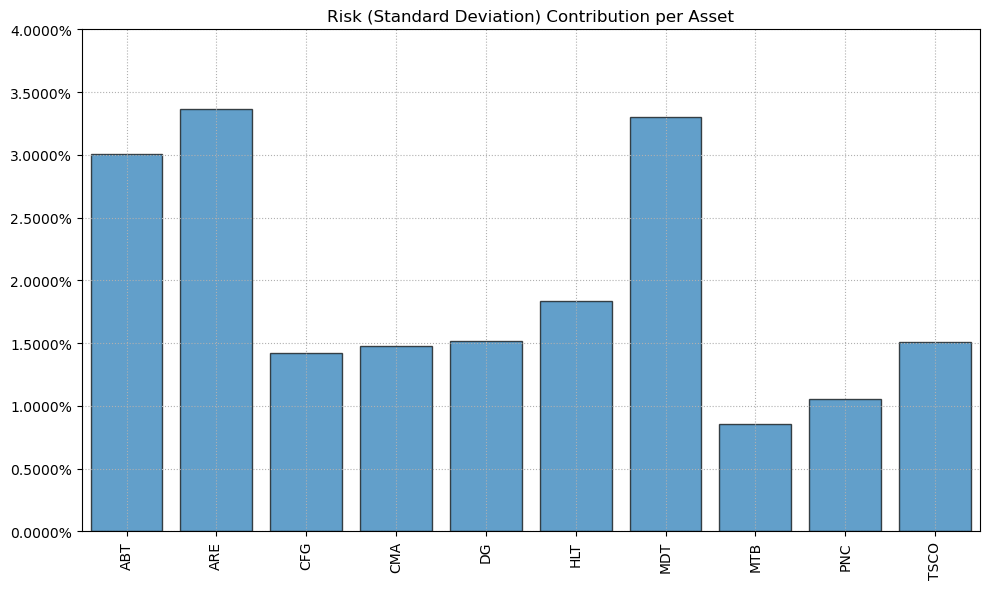

In [12]:
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime.now().strftime("%Y-%m-%d") 
portfolio_list.sort()
##factors = ['MTUM', 'QUAL', 'VLUE', 'SIZE', 'USMV']
#factors.sort()
portfolioTickers = portfolio_list #+ factors
portfolioTickers.sort()
portfolioData = yf.download(portfolioTickers, start = start, end = end)
portfolioData = portfolioData.loc[:,('Adj Close', slice(None))]
portfolioData.columns = portfolioTickers
#X = portfolioData[factors].pct_change().dropna()
Y = portfolioData[portfolio_list].pct_change().dropna()
#Y = portfolioData[portfolio_list].copy()
#Y = Y.resample('M').last().pct_change().dropna()
#port = rp.Portfolio(returns=Y)
port = rp.HCPortfolio(returns=Y)
"""
method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.
port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
l = 0 # Risk aversion factor, only useful when obj is 'Utility'
"""
model='HRP' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'single' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram
#w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

# Plotting the risk contribution per asset

mu = Y.mean()
cov = Y.cov() # Covariance matrix
returns = Y # Returns of the assets

ax = rp.plot_risk_con(w=w,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)
print(w.weights)

In [13]:

target_portfolio = pd.DataFrame(columns=['tickers', 'weight', 'mkt_price'])
target_portfolio['tickers'] = portfolio_list
target_portfolio['weight'] = list(w.weights)
target_portfolio['mkt_price'] = mkt_df['mkt_price']

In [14]:
target_portfolio['quantity'] = np.floor(target_portfolio['weight'] * (total_value * 0.95) / target_portfolio['mkt_price'])

In [15]:
last_portfolio

,ticker,quantity,marketPrice,marketValue,averageCost,unrealizedPNL,realizedPNL
0,BAC,2771,30.007023,83149.46,28.575000,3968.14,0.0
1,CCL,8204,9.506001,77987.23,9.785186,-2290.44,0.0
2,DISH,9768,7.645000,74676.36,8.901757,-12276.00,0.0
3,F,6229,11.816000,73601.86,12.455000,-3980.33,0.0
4,FITB,2990,28.044001,83851.56,26.485000,4661.41,0.0
5,FRC,5711,13.814000,78891.75,13.995000,-1033.69,0.0
6,NUE,534,157.969528,84355.73,146.862491,5931.16,0.0
7,VFC,3659,22.983999,84098.45,21.895000,3984.65,0.0
8,VTRS,8037,9.743903,78311.75,9.895000,-1214.37,0.0
9,ZION,2605,31.225983,81343.68,30.710539,1342.73,0.0


In [16]:
target_portfolio

,tickers,weight,mkt_price,quantity
0,ABT,0.167674,112.29,1183.0
1,ARE,0.180284,125.24,1140.0
2,CFG,0.048061,30.50,1248.0
3,CMA,0.050454,47.09,849.0
4,DG,0.114490,216.51,419.0
5,HLT,0.089630,146.99,483.0
6,MDT,0.179211,129.61,1095.0
7,MTB,0.035071,84.87,327.0
8,PNC,0.043384,128.37,267.0
9,TSCO,0.091741,246.82,294.0


# figure out the best order of our order. (To save commission fee)

* target_portfolio
> target_portfolio python pandas dataframe containing information of stocks portfolio(target portfolio) that I want to form through trading. The first column of the dataframe is stocks' tickers and the second column of the dataframe is the quantity of each stock that I want to hold. 

* last_portfolio
> last_portfolio is a dataframe containing information of last portfolio that I hold

In [17]:
# Create a list to store the stocks that need to be sold
stocks_to_sell = []
# Create a list to store the stocks that need to buy
stocks_to_buy = []

# Iterate through the target_portfolio dataframe
for index, row in target_portfolio.iterrows():
    # Check if the stock is present in the last_portfolio dataframe
    last_portfolio_stock = last_portfolio[last_portfolio['ticker'] == row['tickers']]
    if not last_portfolio_stock.empty:
        # Compare the quantities
        last_portfolio_quantity = float(last_portfolio_stock['quantity'].values[0])
        if row['quantity'] < last_portfolio_quantity:
            # Calculate the difference in quantity
            quantity_diff = last_portfolio_quantity - row['quantity'] 
            # Add the stock to the list of stocks to sell
            stocks_to_sell.append([row['tickers'], quantity_diff])

        if row['quantity'] > last_portfolio_quantity:
            # Calculate the difference in quantity
            quantity_diff = row['quantity'] - last_portfolio_quantity 
            # Add the stock to the list of stocks to buy
            stocks_to_buy.append([row['tickers'], quantity_diff])

# we also need to sell the stocks that are in last_portfolio but not in target_portfolio
# Find the difference between the two portfolios
new_tickers_to_sell = set(last_portfolio['ticker']).difference(set(target_portfolio['tickers']))

for ticker in new_tickers_to_sell:
    # Find the quantity of the stock to sell from the last_portfolio
    quantity = last_portfolio.loc[last_portfolio['ticker'] == ticker, 'quantity'].values[0]
    # append to stocks to sell
    if quantity != 0:
        stocks_to_sell.append([ticker, quantity])

# we also need to buy the stocks that are in target_protfolio but not in last_portfolio
# Find the difference between the two portfolios
new_tickers_to_buy = set(target_portfolio['tickers']).difference(set(last_portfolio['ticker']))

for ticker in new_tickers_to_buy:
    # Find the quantity of the stock to buy from the target_portfolio
    quantity = target_portfolio.loc[target_portfolio['tickers'] == ticker, 'quantity'].values[0]
    # append to stocks to buy
    if quantity != 0:
        stocks_to_buy.append([ticker, quantity])

In [18]:
stocks_to_buy

[['HLT', 483.0],
 ['MTB', 327.0],
 ['TSCO', 294.0],
 ['ABT', 1183.0],
 ['MDT', 1095.0],
 ['PNC', 267.0],
 ['ARE', 1140.0],
 ['DG', 419.0],
 ['CFG', 1248.0],
 ['CMA', 849.0]]

In [19]:
stocks_to_sell

[['BAC', Decimal('2771')],
 ['CCL', Decimal('8204')],
 ['FITB', Decimal('2990')],
 ['FRC', Decimal('5711')],
 ['ZION', Decimal('2605')],
 ['VFC', Decimal('3659')],
 ['F', Decimal('6229')],
 ['VTRS', Decimal('8037')],
 ['NUE', Decimal('534')],
 ['DISH', Decimal('9768')]]

# place order

In [20]:
app.reqIds(-1) # require a new id
id_event.wait()
id_event.clear()
orderid = app.nextValidOrderId
for stock in stocks_to_sell:
    # Replace the place holder values with the appropriate values
    ticker = stock[0]
    quantity = stock[1]
    contract = Contract()
    contract.symbol = ticker
    contract.secType = "STK"
    contract.exchange = "SMART"
    contract.currency = "USD"
    order = Order()
    order.action = "SELL"
    order.orderType = "MKT"
    order.totalQuantity = quantity
    order.tif = "GTC" # default is day order

    orderid += 1

    app.placeOrder(orderid, contract, order)
    order_event.wait()
    order_event.clear()

count = 0
for stock in stocks_to_buy:
    # Replace the place holder values with the appropriate values
    app.reqAccountUpdates(False, "DU6730183")#TODO: replace the DU222526 with our account ID
    app.reqAccountSummary(9001, "All", "SettledCash")
    value_event.wait()
    value_event.clear()
    cash_value = app.value
    if count >= len(stocks_to_buy)/2 and cash_value <= 0:
        break # stop buying when cash is below 0
    ticker = stock[0]
    quantity = stock[1]
    contract = Contract()
    contract.symbol = ticker
    contract.secType = "STK"
    contract.exchange = "SMART"
    contract.currency = "USD"
    order = Order()
    order.action = "BUY"
    order.orderType = "MKT"
    order.totalQuantity = quantity
    order.tif = "GTC" # default is day order

    orderid += 1
    app.placeOrder(orderid, contract, order)
    order_event.wait()
    order_event.clear()
    count +=1

NextValidId: 155
openOrder. orderId:156, contract:10098,BAC,STK,,0,?,,SMART,,USD,BAC,BAC,False,,,,combo:, order:156,1000,393311592: MKT SELL 2771@29.98 GTC
orderStatus. orderId: 156, status: PreSubmitted, filled: 0, remaining:2771, avgFillPrice: 0.0, permId:393311592, parentId:0, lastFillPrice: 0.0, clientId: 1000, whyHeld: , mktCapPrice:0.0
execDetails. reqId: -1, contract: 10098,BAC,STK,,0,,,IEX,,USD,BAC,BAC,False,,,,combo:, execution: ExecId: 0000e0d5.6450bfdc.01.01, Time: 20230420 13:27:57 US/Eastern, Account: DU6730183, Exchange: IEX, Side: SLD, Shares: 200, Price: 29.98, PermId: 393311592, ClientId: 1000, OrderId: 156, Liquidation: 0, CumQty: 200, AvgPrice: 29.98, OrderRef: , EvRule: , EvMultiplier: 0, ModelCode: , LastLiquidity: 2
openOrder. orderId:156, contract:10098,BAC,STK,,0,?,,SMART,,USD,BAC,BAC,False,,,,combo:, order:156,1000,393311592: MKT SELL 2771@29.98 GTC
orderStatus. orderId: 156, status: PreSubmitted, filled: 200, remaining:2571, avgFillPrice: 29.98, permId:3933115

In [21]:
app.disconnect()